In [1]:
import os
import tarfile
import pickle
import numpy as np
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import torch.optim as optim
import random
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm # progress bar to follow the extraction
from torchvision import transforms

In [2]:
# Let's begin with extracting the files from the .tar file

# Path to train.tar file and extract path
file_path = "./cifar-10-python.tar.gz"
extract_path = "./cifar-10-python" 

# Create the target directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Function to simply check if a directory is empty
def is_directory_empty(directory):
    return not any(os.scandir(directory))

# Check if the target directory is empty
if is_directory_empty(extract_path):
    # Extract the files only if the directory is empty
    with tarfile.open(file_path, 'r') as tar:
        # Use tqdm to create a progress bar, so we can follow the extraction progress
        progress_bar = tqdm(tar.getmembers(), desc="Extracting")
        
        # Extract all files
        for member in progress_bar:
            tar.extract(member, path=extract_path)
            progress_bar.update(1)  # Update the progress bar

    print(f"Successfully extracted '{file_path}' to '{extract_path}'.")
else:
    print("Files have already been extracted.")
    

Files have already been extracted.


In [3]:
# Method given in cifar readme
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict[b'data'], dict[b'labels']

# Load the data to memory
training_batch_1 = "cifar-10-python/cifar-10-batches-py/data_batch_1"
training_batch_2 = "cifar-10-python/cifar-10-batches-py/data_batch_2"
training_batch_3 = "cifar-10-python/cifar-10-batches-py/data_batch_3"
training_batch_4 = "cifar-10-python/cifar-10-batches-py/data_batch_4"
training_batch_5 = "cifar-10-python/cifar-10-batches-py/data_batch_5"
test_batch = "cifar-10-python/cifar-10-batches-py/test_batch"

training_data_1, training_labels_1 = unpickle(training_batch_1)
training_data_2, training_labels_2 = unpickle(training_batch_2)
training_data_3, training_labels_3 = unpickle(training_batch_3)
training_data_4, training_labels_4 = unpickle(training_batch_4)
training_data_5, training_labels_5 = unpickle(training_batch_5)
testing_data, testing_labels = unpickle(test_batch)

# Concatenate the training data and labels into one large dataset
training_data = np.concatenate([training_data_1, training_data_2, training_data_3, training_data_4, training_data_5])
training_labels = np.concatenate([training_labels_1, training_labels_2, training_labels_3, training_labels_4, training_labels_5])

# Ensure that testing data and labels are also np.array
testing_data = np.array(testing_data)
testing_labels = np.array(testing_labels)


In [4]:
# Let's select all classes the dataset has
selected_classes = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Choose the data from the classes
train_mask = np.isin(training_labels, selected_classes)
training_data = training_data[train_mask]
training_labels = training_labels[train_mask]

test_mask = np.isin(testing_labels, selected_classes)
testing_data = testing_data[test_mask]
testing_labels = testing_labels[test_mask]

# Split the training data to a new training data and validation data
class_indices = [[] for i in range(10)]
for i, v in enumerate(training_labels):
    class_indices[v].append(i)

# Randomize the order of indices
all_indices = np.random.permutation(len(class_indices[0]))

# Take the first 1500 indices
indices = all_indices[:1500]

# Take the rest of the indices
indices_rest = all_indices[1500:]

validation_indices = []
training_indices = []
for i in range(10):
    validation_indices.extend(np.array(class_indices[i])[indices])
    training_indices.extend(np.array(class_indices[i])[indices_rest])

# Write the custom dataset based on the dataset
class cifar10(Dataset):
    """cifar10 dataset"""

    def __init__(self, phase="train", transform=None):

        if phase == "train":
            self.data = training_data[training_indices]
            self.label = training_labels[training_indices]

        elif phase == "validation":
            self.data = training_data[validation_indices]
            self.label = training_labels[validation_indices]

        elif phase == "test":
            self.data = testing_data
            self.label = testing_labels

        else:
            raise ValueError("Invalid phase.")

        self.transform = transform
        self.label_names = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):

        # Get image and label according to the index
        img, label = self.data[index], self.label[index]

        # Convert image to PyTorch tensor and normalize
        img = img.astype(np.float32) / 255.0  # Convert to float and normalize
        img = np.transpose(img.reshape(3, 32, 32), (1, 2, 0))  # Reshape and transpose to (H, W, C)
            
        if self.transform is not None:
            img = self.transform(img)

        return img, label
        

In [5]:
def print_random_images(dataset, num_images=10):
    # Select random images from the dataset
    random_images = np.random.choice(range(len(dataset)), num_images, replace=False)
    
    # Plot the images in a row
    plt.figure(figsize=(15, 3))
    for i in range(len(random_images)):
        image, label = training_set[random_images[i]] 
        label_name = training_set.label_names[label]
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(f"{label_name}")
        plt.axis('off')
    plt.show()

def print_image_amount(dataset):
    
    # print number of images for each class
    print(f"total number of images: {len(dataset)}")
    for i in range(10):
        print(f"number of images for class {dataset.label_names[i]}: {np.sum(dataset.label==i)}")

training_set = cifar10(phase="train", transform=None)
testing_set = cifar10(phase="test", transform=None)
validation_set = cifar10(phase="validation", transform=None)


Random Images from Training Dataset:


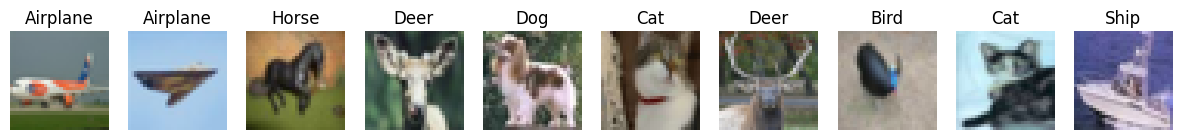

total number of images: 35000
number of images for class Airplane: 3500
number of images for class Automobile: 3500
number of images for class Bird: 3500
number of images for class Cat: 3500
number of images for class Deer: 3500
number of images for class Dog: 3500
number of images for class Frog: 3500
number of images for class Horse: 3500
number of images for class Ship: 3500
number of images for class Truck: 3500


Random Images from Testing Dataset:


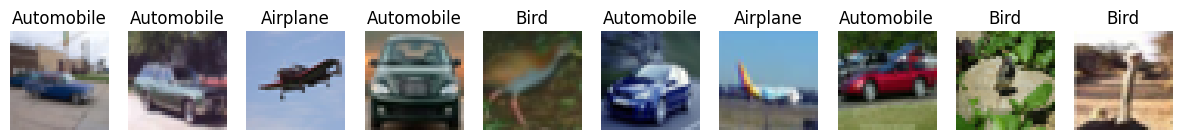

total number of images: 10000
number of images for class Airplane: 1000
number of images for class Automobile: 1000
number of images for class Bird: 1000
number of images for class Cat: 1000
number of images for class Deer: 1000
number of images for class Dog: 1000
number of images for class Frog: 1000
number of images for class Horse: 1000
number of images for class Ship: 1000
number of images for class Truck: 1000


Random Images from Validation Dataset:


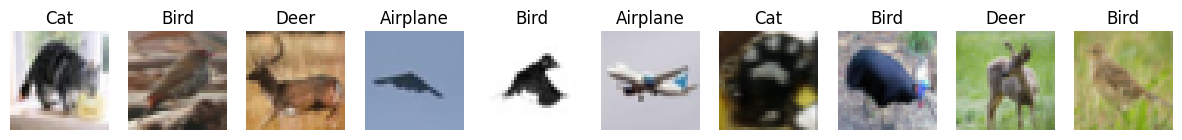

total number of images: 15000
number of images for class Airplane: 1500
number of images for class Automobile: 1500
number of images for class Bird: 1500
number of images for class Cat: 1500
number of images for class Deer: 1500
number of images for class Dog: 1500
number of images for class Frog: 1500
number of images for class Horse: 1500
number of images for class Ship: 1500
number of images for class Truck: 1500


In [6]:
# Print 10 random images from each class for training, testing, and validation datasets
# to see that the labeling works
print("Random Images from Training Dataset:")
print_random_images(training_set)
print_image_amount(training_set)
print("\n")
    
print("Random Images from Testing Dataset:")
print_random_images(testing_set)
print_image_amount(testing_set)
print("\n")

print("Random Images from Validation Dataset:")
print_random_images(validation_set)
print_image_amount(validation_set)

In [7]:
# Transform the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normalize pixel values
])

batch_size = 256
num_workers = 0

# Transform the sets
training_set = cifar10(phase="train", transform=transform)
testing_set = cifar10(phase="test", transform=transform)
validation_set = cifar10(phase="validation", transform=transform)

# Dataloaders
training_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
testing_loader = DataLoader(testing_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)


In [8]:
# Simple CNN model, similar to one we did in our DL course
class Network(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(2304, batch_size)
        
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(batch_size, num_classes)
        
    def forward(self, x):
        x = self.conv1(x) 
        x = self.bn1(x)  
        x = self.relu1(x)  
        x = self.pool(x)

        x = self.conv2(x) 
        x = self.bn2(x)  
        x = self.relu2(x)  
        x = self.pool2(x)
        
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)

        return x
        

In [22]:
# Instantiate a network
net = Network(num_classes=10)

# Evaluation function
def eval(net, data_loader):
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()
    net.eval()
    correct = 0.0
    num_images = 0.0
    for i_batch, (images, labels) in enumerate(data_loader):
        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()
        outs = net(images) 
        preds = outs.argmax(dim=1)
        correct += preds.eq(labels).sum()
        num_images += len(labels)

    acc = correct / num_images
    return acc

# Training function
def train(net, train_loader, validation_loader):
    loss_function = torch.nn.CrossEntropyLoss()

    optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9, weight_decay=0)

    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()
        
    epoches = 20
    acc_list = []
    loss_list = []
    val_acc_list = []
    for epoch in range(epoches):
        net.train() 
        correct = 0.0 # Used to accumulate number of correctly recognized images
        num_images = 0.0 # Used to accumulate number of images
        for i_batch, (images, labels) in enumerate(train_loader):
            if use_cuda:
                images = images.cuda()
                labels = labels.cuda()

            outs = net(images)
            labels = labels.long() # Make sure labels are long type
            loss = loss_function(outs, labels)

            # Backward propagation
            optimizer.zero_grad() # Clear old gradients
            loss.backward() # Calculate gradients of parameters
            optimizer.step() # Gradient descent algorithm

            preds = outs.argmax(dim=1)
            correct += preds.eq(labels).sum()
            num_images += len(labels)
            
        acc = correct / num_images
        acc_eval = eval(net, validation_loader)
        val_acc_list.append(acc_eval)
        acc_list.append(acc)
        loss_list.append(loss.item())
        print("epoch: %d, lr: %f, accuracy: %f, loss: %f, valid accuracy: %f" % (epoch, optimizer.param_groups[0]['lr'], acc, loss.item(), acc_eval))

    # Plotting accuracy and losses side by side
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
    
    # Plot training accuracy
    axs[0].plot(acc_list, label="Training Accuracy")
    axs[0].plot(val_acc_list, label="Validation Accuracy", linestyle="dashed", color="orange")  # Dashed line for validation accuracy
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()

    # Plot losses
    axs[1].plot(loss_list, label="Losses")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend()

    plt.tight_layout()  # Ensures proper spacing between subplots
    plt.show()
    return net

Please wait, it will take time!
epoch: 0, lr: 0.005000, accuracy: 0.428400, loss: 1.347625, valid accuracy: 0.534067
epoch: 1, lr: 0.005000, accuracy: 0.576286, loss: 1.186089, valid accuracy: 0.600467
epoch: 2, lr: 0.005000, accuracy: 0.634600, loss: 1.018288, valid accuracy: 0.592067
epoch: 3, lr: 0.005000, accuracy: 0.665943, loss: 1.011728, valid accuracy: 0.656667
epoch: 4, lr: 0.005000, accuracy: 0.691286, loss: 0.770632, valid accuracy: 0.676400
epoch: 5, lr: 0.005000, accuracy: 0.711457, loss: 0.805815, valid accuracy: 0.639467
epoch: 6, lr: 0.005000, accuracy: 0.734543, loss: 0.708544, valid accuracy: 0.684867
epoch: 7, lr: 0.005000, accuracy: 0.748829, loss: 0.691189, valid accuracy: 0.681467
epoch: 8, lr: 0.005000, accuracy: 0.767457, loss: 0.655317, valid accuracy: 0.685067
epoch: 9, lr: 0.005000, accuracy: 0.783257, loss: 0.715011, valid accuracy: 0.701800
epoch: 10, lr: 0.005000, accuracy: 0.801286, loss: 0.680322, valid accuracy: 0.688933
epoch: 11, lr: 0.005000, accurac

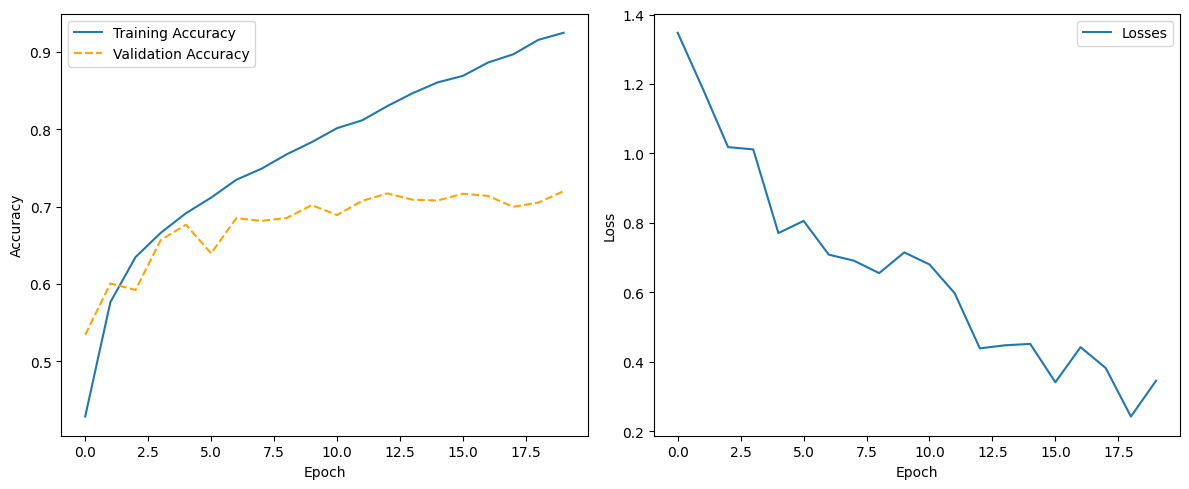

Accuracy on testing data: 0.724700


In [23]:
print("Please wait, it will take time!")
# Training the network
net = train(net, training_loader, validation_loader)

# Test the network
acc_test = eval(net, testing_loader)

print('Accuracy on testing data: %f' % acc_test)

In [11]:
# Added two fully-connected layers to the Network
class secondNetwork(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(2304, batch_size)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(batch_size, 256)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(256, 128)  # Adding a new fully connected layer with 128 units
        self.relu5 = nn.ReLU()
        self.fc4 = nn.Linear(128, 64)  # Adding a new fully connected layer with 64 units

    def forward(self, x):
        x = self.conv1(x) 
        x = self.bn1(x)  
        x = self.relu1(x)  
        x = self.pool(x)

        x = self.conv2(x) 
        x = self.bn2(x)  
        x = self.relu2(x)  
        x = self.pool2(x)
        
        x = x.view(x.size(0), -1) 

        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.fc3(x)
        x = self.relu5(x)
        x = self.fc4(x)

        return x

In [20]:
# We can try scheduling our learning rate and see the effects
from torch.optim.lr_scheduler import StepLR

net = secondNetwork(num_classes=10)

# Evaluation function with added validation loss check up
def val_eval(net, data_loader, loss_function):
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()
    net.eval()
    correct = 0.0
    num_images = 0.0
    val_loss = 0.0  # Initialize val_loss
    for i_batch, (images, labels) in enumerate(data_loader):
        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()
            
        outs = net(images) 
        labels = labels.long()
        loss = loss_function(outs, labels)
        preds = outs.argmax(dim=1)
        correct += preds.eq(labels).sum()
        num_images += len(labels)
        val_loss += loss.item()
    
    # Calculate average validation loss
    val_loss /= len(data_loader.dataset)
    
    # Calculate validation accuracy
    val_acc = correct / num_images
    
    return val_loss, val_acc

# Add a weight penalty to training, change starting learning rate
def train(net, train_loader, validation_loader):
    loss_function = torch.nn.CrossEntropyLoss()

    optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()
        
    epoches = 30
    acc_list = []
    loss_list = []
    val_acc_list = []
    val_loss_list = []
    for epoch in range(epoches):
        net.train() 
        correct = 0.0 # Used to accumulate number of correctly recognized images
        num_images = 0.0 # Used to accumulate number of images
        for i_batch, (images, labels) in enumerate(train_loader):
            if use_cuda:
                images = images.cuda()
                labels = labels.cuda()  # Convert labels to long type
            outs = net(images)
            labels = labels.long() # Make sure labels are long type
            loss = loss_function(outs, labels)

            # Backward propagation
            optimizer.zero_grad() # Clear old gradients
            loss.backward() # Calculate gradients of parameters
            optimizer.step() # Gradient descent algorithm

            preds = outs.argmax(dim=1)
            correct += preds.eq(labels).sum()
            num_images += len(labels)

            
        acc = correct / num_images
        val_loss, acc_eval = val_eval(net, validation_loader, loss_function)
        val_acc_list.append(acc_eval)
        val_loss_list.append(val_loss)
        acc_list.append(acc)
        loss_list.append(loss.item())
        scheduler.step() # Update lr
        print("epoch: %d, lr: %f, accuracy: %f, loss: %f, valid accuracy: %f, valid loss: %f" % (epoch, optimizer.param_groups[0]['lr'], acc, loss.item(), acc_eval, val_loss))

    # Plotting accuracy and losses side by side
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
    
    # Plot training accuracy
    axs[0].plot(acc_list, label="Training Accuracy")
    axs[0].plot(val_acc_list, label="Validation Accuracy", linestyle="dashed", color="orange")  # Dashed line for validation accuracy
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()

    # Plot losses
    axs[1].plot(loss_list, label="Losses")
    axs[1].plot(val_loss_list, label="Validation losses", linestyle="dashed", color="orange")  # Dashed line for validation loss
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend()

    plt.tight_layout()  # Ensures proper spacing between subplots
    plt.show()
    return net


Please wait, it will take time!
epoch: 0, lr: 0.005000, accuracy: 0.205686, loss: 1.752494, valid accuracy: 0.347933, valid loss: 0.006861
epoch: 1, lr: 0.005000, accuracy: 0.413629, loss: 1.631152, valid accuracy: 0.476800, valid loss: 0.005554
epoch: 2, lr: 0.005000, accuracy: 0.509057, loss: 1.264374, valid accuracy: 0.539333, valid loss: 0.004943
epoch: 3, lr: 0.005000, accuracy: 0.567886, loss: 1.287969, valid accuracy: 0.572267, valid loss: 0.004615
epoch: 4, lr: 0.005000, accuracy: 0.613886, loss: 1.043520, valid accuracy: 0.607867, valid loss: 0.004335
epoch: 5, lr: 0.005000, accuracy: 0.644914, loss: 1.049373, valid accuracy: 0.620067, valid loss: 0.004271
epoch: 6, lr: 0.005000, accuracy: 0.670114, loss: 0.912662, valid accuracy: 0.640267, valid loss: 0.004008
epoch: 7, lr: 0.005000, accuracy: 0.691886, loss: 0.822848, valid accuracy: 0.658200, valid loss: 0.003813
epoch: 8, lr: 0.005000, accuracy: 0.706371, loss: 0.948582, valid accuracy: 0.643067, valid loss: 0.004079
epoch

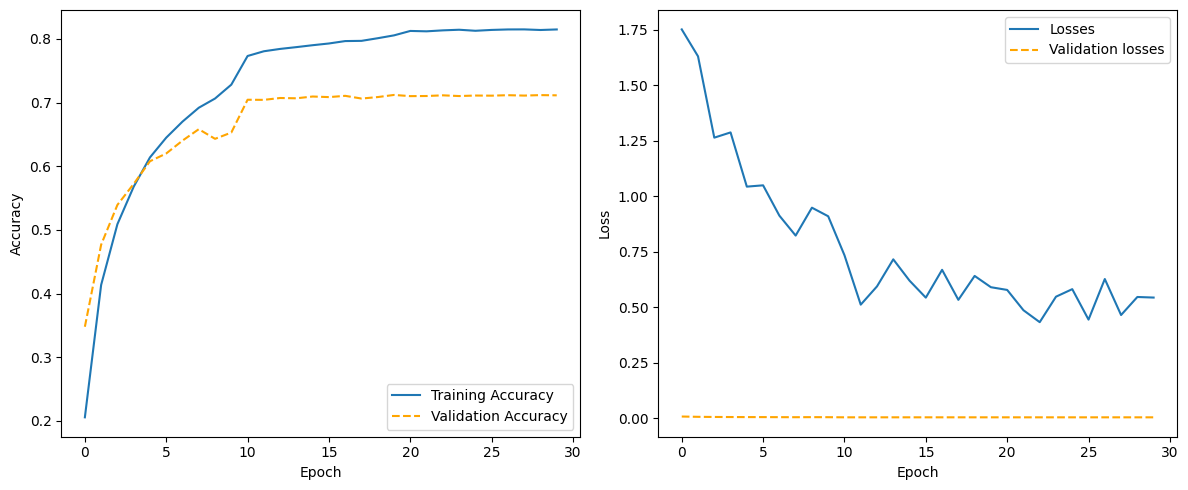

Accuracy on testing data: 0.713500


In [21]:
print("Please wait, it will take time!")
# Train the network
net = train(net, training_loader, validation_loader)

# Test the network
acc_test = eval(net, testing_loader)

print("Accuracy on testing data: %f" % acc_test)
